In [1]:
import sys

sys.path.append("../src")

from deep_learning_models import *
from deep_learning_functions import my_f1

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Concatenate
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split

Matplotlib created a temporary config/cache directory at /var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/matplotlib-2a1yvk7t because the default path (/Users/ibemmene/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [87]:
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/model_evaluation/all_10fold/")
assert results_dir.exists()

In [60]:
plot_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/notebooks/plots/")

In [3]:
n_kfolds = 10



In [4]:
models = [
        ('BiLSTM_Dense', BiLSTMDenseModel()),
        ('BiLSTM_Dense2', BiLSTMDenseModel_2()),
        ('BiLSTM_LSTM_Dense', BiLSTM_LSTMDenseModel()),
        ('BiLSTM_LSTM_doubleDense', BiLSTM_LSTM_doubleDenseModel()),
        ('BiLSTM_doubleDense2', BiLSTM_doubleDenseModel_2),
        #('BiLSTM_LSTM' ,BiLSTM_LSTMModel()),
        ('BiLSTM',BiLSTMModel())
    ]

Metal device set to: Apple M1


2023-03-02 14:25:55.304597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 14:25:55.305064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**Definitions**

In [5]:
from os import listdir, chdir
import glob

In [15]:
n_epochs = 500

In [67]:
def plot_learning_curve(model_name, dataset, val = True):
    #plt.figure()
    ax = plt.subplot(111)
    
    model_names = {'BiLSTM_Dense': "Model 2",
                  'BiLSTM_Dense2': "Model 3",
                  'BiLSTM': "Model 1",
                  'BiLSTM_LSTM_Dense': "Model 4"}
    
    plt.title(f"Learning Curve {model_names[model_name]}")
    
    precision_val = np.zeros(n_epochs)
    precision = np.zeros(n_epochs)
    
    recall_val = np.zeros(n_epochs)
    recall = np.zeros(n_epochs)
    
    
    for k in range(n_kfolds):
        chdir(Path(results_dir/f"{model_name}/kfold_{k}/"))
        
        precision_val += np.load(glob.glob("val_precision*")[0])
        recall_val  += np.load(glob.glob("val_recall*")[0])
        
        precision += np.load(glob.glob("precision*")[0])
        recall  += np.load(glob.glob("recall*")[0])
            
            
    precision_val = precision_val/n_kfolds
    recall_val = recall_val/n_kfolds
    
    precision = precision/n_kfolds
    recall = recall/n_kfolds
        
        
    f1 = my_f1(precision, recall)
    f1_val = my_f1(precision_val, recall_val)
        
    ax.plot(f1, color = "C0", label = "Train")
    ax.plot(f1_val, color = "C1", label = "Validation")
    
    ax.spines[['right', 'top']].set_visible(False)
       
        
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    
    chdir(Path(results_dir/f"{model_name}/kfold_{k}/"))
    
    plt.legend(frameon = False, loc = (0.7,0.25))
    plt.savefig(plot_dir/f"{dataset}_{model_name}_train_val_curve.png")

In [7]:
def retrieve_minval_score(model_name):
    mean_f1= 0
    mean_val_f1 = 0
    mean_re = 0
    mean_val_re = 0
    mean_prec = 0
    mean_val_prec = 0
    
    for k in range(n_kfolds):
        chdir(Path(results_dir/f"{model_name}/kfold_{k}/"))
        val_loss = np.load(glob.glob("val_loss*")[0])
        precision = np.load(glob.glob("precision*")[0])
        recall  = np.load(glob.glob("recall*")[0])
        
        val_precision = np.load(glob.glob("val_precision*")[0])
        val_recall  = np.load(glob.glob("val_recall*")[0])
        f1 = my_f1(precision, recall)
        val_f1 = my_f1(val_precision, val_recall)
        
        minval_i = np.argmin(val_loss)
        
        mean_f1 += f1[minval_i]
        mean_val_f1 += val_f1[minval_i]
        
        mean_re += recall[minval_i]
        mean_val_re += val_recall[minval_i]
        
        mean_prec += precision[minval_i]
        mean_val_prec += val_precision[minval_i]
        
        
    return mean_f1/n_kfolds, mean_val_f1/n_kfolds, mean_re/n_kfolds, mean_val_re/n_kfolds, mean_prec/n_kfolds, mean_val_prec/n_kfolds
        

**Look at learning Curves, all data together**

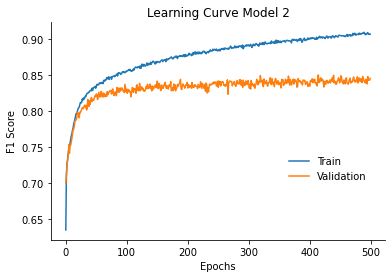

In [88]:
plot_learning_curve("BiLSTM_Dense", "all")

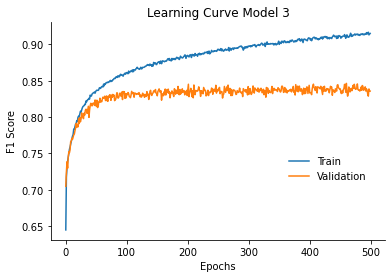

In [89]:
plot_learning_curve("BiLSTM_Dense2", "all")


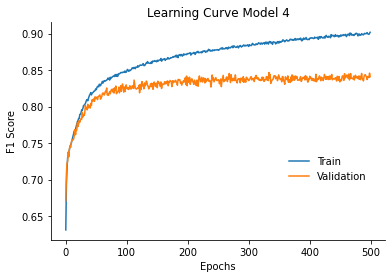

In [90]:
plot_learning_curve("BiLSTM_LSTM_Dense", "all")

In [91]:
plot_learning_curve("BiLSTM", "all")

## Results all together

In [9]:
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/model_evaluation/all_10fold/")
assert results_dir.exists()


In [10]:
results = []
for model_name,_ in models:
    f1, f1_val, recall, recall_val, precision, precision_val = retrieve_minval_score(model_name)
    result = pd.DataFrame({"model": [model_name], "F1_train": ["{:.3f}".format(f1)], "F1_val": ["{:.3f}".format(f1_val)], "recall_train": ["{:.3f}".format(recall)], "recall_val": ["{:.3f}".format(recall_val)], "precision_train": ["{:.3f}".format(precision)], "precision_val": ["{:.3f}".format(precision_val)]})
    results.append(result)
    
results = pd.concat(results)
results= results.reset_index(drop = True)

    
        

In [11]:
results

model F1_train F1_val recall_train recall_val  \
0             BiLSTM_Dense    0.876  0.843        0.825      0.801   
1            BiLSTM_Dense2    0.869  0.847        0.821      0.801   
2        BiLSTM_LSTM_Dense    0.869  0.834        0.821      0.781   
3  BiLSTM_LSTM_doubleDense    0.871  0.838        0.821      0.785   
4      BiLSTM_doubleDense2    0.870  0.843        0.821      0.788   
5                   BiLSTM    0.765  0.776        0.687      0.697   

  precision_train precision_val  
0           0.934         0.890  
1           0.923         0.900  
2           0.923         0.895  
3           0.927         0.899  
4           0.925         0.906  
5           0.863         0.877

In [12]:
print(results.to_latex(index=False)) 

\begin{tabular}{lllllll}
\toprule
                  model & F1\_train & F1\_val & recall\_train & recall\_val & precision\_train & precision\_val \\
\midrule
           BiLSTM\_Dense &    0.876 &  0.843 &        0.825 &      0.801 &           0.934 &         0.890 \\
          BiLSTM\_Dense2 &    0.869 &  0.847 &        0.821 &      0.801 &           0.923 &         0.900 \\
      BiLSTM\_LSTM\_Dense &    0.869 &  0.834 &        0.821 &      0.781 &           0.923 &         0.895 \\
BiLSTM\_LSTM\_doubleDense &    0.871 &  0.838 &        0.821 &      0.785 &           0.927 &         0.899 \\
    BiLSTM\_doubleDense2 &    0.870 &  0.843 &        0.821 &      0.788 &           0.925 &         0.906 \\
                 BiLSTM &    0.765 &  0.776 &        0.687 &      0.697 &           0.863 &         0.877 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_44069/516983427.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


In [11]:
results

model F1_train F1_val recall_train recall_val precision_train  \
0       BiLSTM_Dense    0.876  0.843        0.825      0.801           0.934   
1      BiLSTM_Dense2    0.869  0.847        0.821      0.801           0.923   
2  BiLSTM_LSTM_Dense    0.869  0.834        0.821      0.781           0.923   
3             BiLSTM    0.765  0.776        0.687      0.697           0.863   

  precision_val  
0         0.890  
1         0.900  
2         0.895  
3         0.877

In [12]:
print(results.to_latex(index=False)) 

\begin{tabular}{lllllll}
\toprule
            model & F1\_train & F1\_val & recall\_train & recall\_val & precision\_train & precision\_val \\
\midrule
     BiLSTM\_Dense &    0.876 &  0.843 &        0.825 &      0.801 &           0.934 &         0.890 \\
    BiLSTM\_Dense2 &    0.869 &  0.847 &        0.821 &      0.801 &           0.923 &         0.900 \\
BiLSTM\_LSTM\_Dense &    0.869 &  0.834 &        0.821 &      0.781 &           0.923 &         0.895 \\
           BiLSTM &    0.765 &  0.776 &        0.687 &      0.697 &           0.863 &         0.877 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_49567/516983427.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


In [12]:
results




model F1_train F1_val recall_train recall_val precision_train  \
0       BiLSTM_Dense    0.848  0.821        0.792      0.757           0.913   
1      BiLSTM_Dense2    0.867  0.831        0.817      0.775           0.923   
2  BiLSTM_LSTM_Dense    0.838  0.805        0.779      0.745           0.906   
3             BiLSTM    0.770  0.769        0.694      0.701           0.865   

  precision_val  
0         0.898  
1         0.895  
2         0.875  
3         0.854

In [13]:
print(results.to_latex(index=False))  

\begin{tabular}{lllllll}
\toprule
            model & F1\_train & F1\_val & recall\_train & recall\_val & precision\_train & precision\_val \\
\midrule
     BiLSTM\_Dense &    0.848 &  0.821 &        0.792 &      0.757 &           0.913 &         0.898 \\
    BiLSTM\_Dense2 &    0.867 &  0.831 &        0.817 &      0.775 &           0.923 &         0.895 \\
BiLSTM\_LSTM\_Dense &    0.838 &  0.805 &        0.779 &      0.745 &           0.906 &         0.875 \\
           BiLSTM &    0.770 &  0.769 &        0.694 &      0.701 &           0.865 &         0.854 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_16930/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


## Results Brazil Gaz

In [92]:
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/model_evaluation/brazil_gaz_10fold/")
assert results_dir.exists()

In [15]:
results = []
for model_name,_ in models:
    f1, f1_val, recall, recall_val, precision, precision_val = retrieve_minval_score(model_name)
    result = pd.DataFrame({"model": [model_name], "F1_train": ["{:.3f}".format(f1)], "F1_val": ["{:.3f}".format(f1_val)], "recall_train": ["{:.3f}".format(recall)], "recall_val": ["{:.3f}".format(recall_val)], "precision_train": ["{:.3f}".format(precision)], "precision_val": ["{:.3f}".format(precision_val)]})
    results.append(result)
    
results = pd.concat(results)
results= results.reset_index(drop = True)

/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/notebooks/../src/deep_learning_functions.py:12: RuntimeWarning: invalid value encountered in true_divide
  return 2 * (precision * recall) / (precision + recall)


In [16]:
results

model F1_train F1_val recall_train recall_val  \
0             BiLSTM_Dense    0.921  0.894        0.910      0.876   
1            BiLSTM_Dense2    0.919  0.894        0.904      0.878   
2        BiLSTM_LSTM_Dense    0.916  0.883        0.900      0.864   
3  BiLSTM_LSTM_doubleDense    0.901  0.882        0.881      0.868   
4      BiLSTM_doubleDense2    0.910  0.889        0.891      0.870   
5                   BiLSTM    0.698  0.704        0.597      0.602   

  precision_train precision_val  
0           0.932         0.914  
1           0.934         0.912  
2           0.932         0.904  
3           0.922         0.898  
4           0.930         0.910  
5           0.846         0.857

In [15]:
results

model F1_train F1_val recall_train recall_val precision_train  \
0       BiLSTM_Dense    0.921  0.894        0.910      0.876           0.932   
1      BiLSTM_Dense2    0.919  0.894        0.904      0.878           0.934   
2  BiLSTM_LSTM_Dense    0.916  0.883        0.900      0.864           0.932   
3             BiLSTM    0.698  0.704        0.597      0.602           0.846   

  precision_val  
0         0.914  
1         0.912  
2         0.904  
3         0.857

In [16]:
print(results.to_latex(index=False))

\begin{tabular}{lllllll}
\toprule
            model & F1\_train & F1\_val & recall\_train & recall\_val & precision\_train & precision\_val \\
\midrule
     BiLSTM\_Dense &    0.921 &  0.894 &        0.910 &      0.876 &           0.932 &         0.914 \\
    BiLSTM\_Dense2 &    0.919 &  0.894 &        0.904 &      0.878 &           0.934 &         0.912 \\
BiLSTM\_LSTM\_Dense &    0.916 &  0.883 &        0.900 &      0.864 &           0.932 &         0.904 \\
           BiLSTM &    0.698 &  0.704 &        0.597 &      0.602 &           0.846 &         0.857 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_49567/2695231829.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


In [16]:
results

model F1_train F1_val recall_train recall_val precision_train  \
0       BiLSTM_Dense    0.912  0.874        0.901      0.849           0.923   
1      BiLSTM_Dense2    0.919  0.887        0.906      0.870           0.932   
2  BiLSTM_LSTM_Dense    0.905  0.878        0.885      0.864           0.927   
3             BiLSTM    0.733  0.726        0.649      0.647           0.849   

  precision_val  
0         0.900  
1         0.905  
2         0.894  
3         0.834

In [17]:
print(results.to_latex(index=False))


\begin{tabular}{lllllll}
\toprule
            model & F1\_train & F1\_val & recall\_train & recall\_val & precision\_train & precision\_val \\
\midrule
     BiLSTM\_Dense &    0.912 &  0.874 &        0.901 &      0.849 &           0.923 &         0.900 \\
    BiLSTM\_Dense2 &    0.919 &  0.887 &        0.906 &      0.870 &           0.932 &         0.905 \\
BiLSTM\_LSTM\_Dense &    0.905 &  0.878 &        0.885 &      0.864 &           0.927 &         0.894 \\
           BiLSTM &    0.733 &  0.726 &        0.649 &      0.647 &           0.849 &         0.834 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_16930/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


## Learning Curves - Brazilian gasoline

In [93]:
plot_learning_curve("BiLSTM", "brazil_gas")

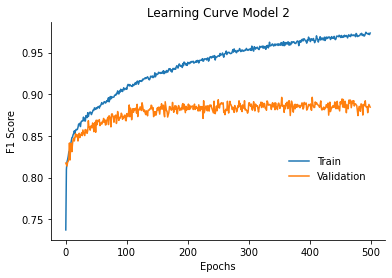

In [94]:
plot_learning_curve("BiLSTM_Dense", "brazil_gas")

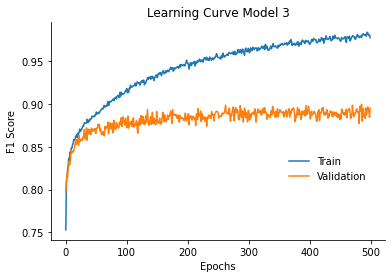

In [95]:
plot_learning_curve("BiLSTM_Dense2", "brazil_gas")

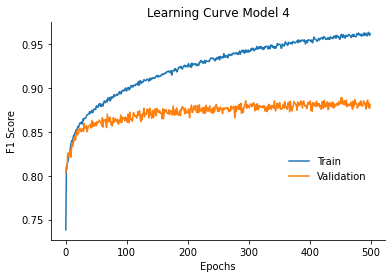

In [96]:
plot_learning_curve("BiLSTM_LSTM_Dense", "brazil_gas")

**Notes**
- Something with BiLSTM_LSTM went wrong - no data- perhaps also not needed

# Evaluation of Leave-one-out Validation with deep learning

In [24]:
def retrieve_minval_score_loo(model_name):
    mean_f1= 0
    mean_val_f1 = 0
    mean_re = 0
    mean_val_re = 0
    mean_prec = 0
    mean_val_prec = 0
    
   
    chdir(Path(results_dir))
    loss = np.load(glob.glob(f"{model_name}_val_loss*")[0])
    val_loss = np.load(glob.glob(f"{model_name}_loss*")[0])
    precision = np.load(glob.glob(f"{model_name}_precision*")[0])
    recall  = np.load(glob.glob(f"{model_name}_recall*")[0])
        
    val_precision = np.load(glob.glob(f"{model_name}_val_precision*")[0])
    val_recall  = np.load(glob.glob(f"{model_name}_val_recall*")[0])
    f1 = my_f1(precision, recall)
    val_f1 = my_f1(val_precision, val_recall)
        
    minval_i = np.argmin(loss)
        
    mean_f1 += f1[minval_i]
    mean_val_f1 += val_f1[minval_i]
        
    mean_re += recall[minval_i]
    mean_val_re += val_recall[minval_i]
        
    mean_prec += precision[minval_i]
    mean_val_prec += val_precision[minval_i]
        
        
    return mean_f1, mean_val_f1, mean_re, mean_val_re, mean_prec, mean_val_prec
        

In [25]:
def plot_learning_curve_loo(model_name, val = True):
    plt.figure()
    plt.title(f"Learning Curve {model_name}")
    
    chdir(Path(results_dir))
    if val:
        precision = np.load(glob.glob(f"{model_name}_val_precision*")[0])
        recall  = np.load(glob.glob(f"{model_name}_val_recall*")[0])
    else:
        precision = np.load(glob.glob(f"{model_name}_precision*")[0])
        recall  = np.load(glob.glob(f"{model_name}_recall*")[0])
              
        
    f1 = my_f1(precision, recall)
    
    plt.plot(f1, ".", label = "F1 score")
        
    plt.xlabel("epochs")
    plt.ylabel("F1 score")
    
    plt.legend(frameon = False)

In [26]:
results_dir = Path("/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/results/leave-one-out/")
dataset_names = ["brazil_gaz", "japan", "brazil", "ticino", "US"] 

results = []
for model_name in dataset_names:
    f1, f1_val, recall, recall_val, precision, precision_val = retrieve_minval_score_loo(model_name)
    result = pd.DataFrame({"model": [model_name], "F1_train": ["{:.3f}".format(f1)], "F1_val": ["{:.3f}".format(f1_val)], "recall_train": ["{:.3f}".format(recall)], "recall_val": ["{:.3f}".format(recall_val)], "precision_train": ["{:.3f}".format(precision)], "precision_val": ["{:.3f}".format(precision_val)]})
    results.append(result)
    
results = pd.concat(results)
results= results.reset_index(drop = True)

/Users/ibemmene/Documents/HSLU/MLCartel/ml-cartel-detection/notebooks/../src/deep_learning_functions.py:12: RuntimeWarning: invalid value encountered in true_divide
  return 2 * (precision * recall) / (precision + recall)


In [27]:
results


model F1_train F1_val recall_train recall_val precision_train  \
0  brazil_gaz    0.643  0.304        0.671      0.234           0.617   
1       japan    0.755  0.856        0.671      0.783           0.863   
2      brazil    0.787  0.550        0.722      0.458           0.866   
3      ticino    0.773  0.886        0.703      0.876           0.860   
4          US    0.800  0.388        0.763      0.573           0.840   

  precision_val  
0         0.433  
1         0.944  
2         0.688  
3         0.897  
4         0.294

In [28]:
print(results.to_latex(index=False)) 

\begin{tabular}{lllllll}
\toprule
     model & F1\_train & F1\_val & recall\_train & recall\_val & precision\_train & precision\_val \\
\midrule
brazil\_gaz &    0.643 &  0.304 &        0.671 &      0.234 &           0.617 &         0.433 \\
     japan &    0.755 &  0.856 &        0.671 &      0.783 &           0.863 &         0.944 \\
    brazil &    0.787 &  0.550 &        0.722 &      0.458 &           0.866 &         0.688 \\
    ticino &    0.773 &  0.886 &        0.703 &      0.876 &           0.860 &         0.897 \\
        US &    0.800 &  0.388 &        0.763 &      0.573 &           0.840 &         0.294 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_16930/516983427.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


In [22]:
print(results.to_latex(index=False))  

\begin{tabular}{lrrrrrr}
\toprule
     model &  F1\_train &   F1\_val &  recall\_train &  recall\_val &  precision\_train &  precision\_val \\
\midrule
brazil\_gaz &  0.633663 & 0.128814 &      0.544350 &    0.082489 &         0.758037 &       0.293814 \\
     japan &  0.563887 & 0.148289 &      0.450623 &    0.082803 &         0.753205 &       0.709091 \\
    brazil &  0.809215 & 0.666667 &      0.754362 &    0.708333 &         0.872671 &       0.629630 \\
    ticino &  0.802518 & 0.913858 &      0.736462 &    0.945736 &         0.881590 &       0.884058 \\
        US &  0.783555 & 0.222951 &      0.739164 &    0.170854 &         0.833619 &       0.320755 \\
\bottomrule
\end{tabular}



/var/folders/kv/34jyv69d3lq7qnz8d_2l_s4w0000gq/T/ipykernel_14930/3872705694.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results.to_latex(index=False))


**Plot the plots**

In [25]:
dataset_names

['brazil_gaz', 'japan', 'brazil', 'ticino', 'US']

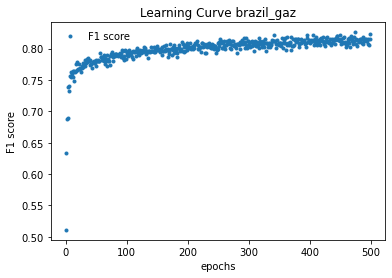

In [53]:
plot_learning_curve_loo("brazil_gaz", val = False)



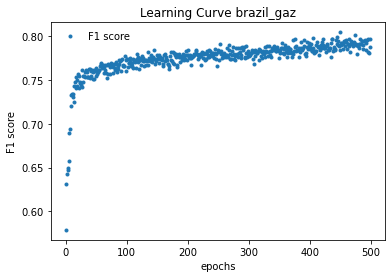

In [29]:
plot_learning_curve_loo("brazil_gaz", val = False)

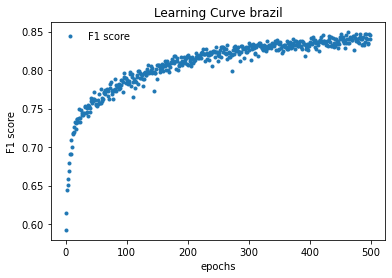

In [54]:
plot_learning_curve_loo("brazil", val = False)

In [30]:
plot_learning_curve_loo("brazil", val = False)

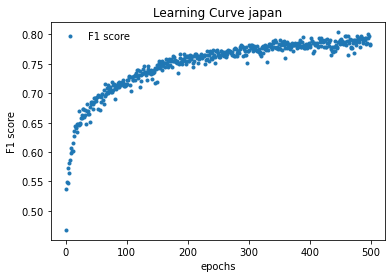

In [56]:
plot_learning_curve_loo("japan", val = False)


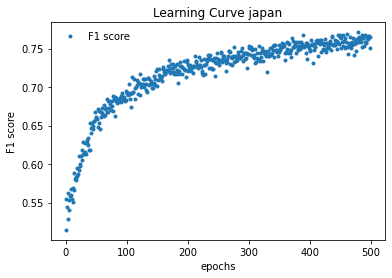

In [31]:
plot_learning_curve_loo("japan", val = False)

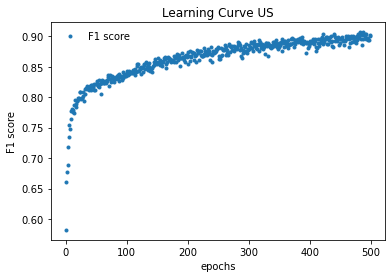

In [57]:
plot_learning_curve_loo("US", val = False)

In [38]:
plot_learning_curve_loo("ticino", val = True)


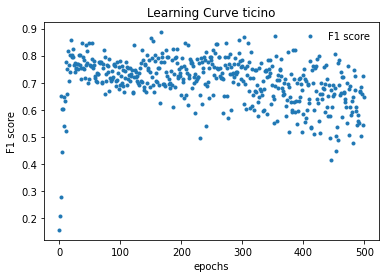

In [32]:
plot_learning_curve_loo("ticino", val = True)

**TODO:** Ask Marc whether how I did training is correct, or whether it needs to be retrained.

## ToDo evaluate on unseen Test Set and calculate embeddings on these